In [79]:
# type: ignore
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
words = open('data/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [81]:
len(words)

32033

In [82]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [83]:
# dataset creation
context_length = 3
# , labels
X, Y = [], []

for w in words:
    context = [0] * context_length
    
    for char in w + '.':
        ind = stoi[char]
        X.append(context)
        Y.append(ind)
        # print(''.join(itos[i] for i in context), '-->', itos[ind])
        context = context[1:] + [ind]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [84]:
X.shape, X.dtype, Y.shape, Y.dtype # type: ignore

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [85]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [86]:
# create 2-dimensional embeddings for each character
C = torch.randn((27, 2))
print(C.shape)
C

torch.Size([27, 2])


tensor([[-0.9117, -0.0442],
        [ 1.4431,  0.8786],
        [ 2.1661, -0.8179],
        [ 0.2654, -0.1707],
        [ 1.2258,  0.8020],
        [-0.0345,  0.0951],
        [-0.4209, -0.5714],
        [-0.1322,  0.8174],
        [-0.3042,  1.7497],
        [-1.3558,  0.5964],
        [ 0.1040, -1.1230],
        [-0.2590, -0.3276],
        [ 1.5547, -0.7847],
        [ 1.2614,  0.3531],
        [-0.9422, -0.7321],
        [-0.2289,  2.8514],
        [ 0.5565,  0.3153],
        [-1.2447, -2.1969],
        [ 0.3196,  0.2600],
        [ 0.2921,  0.6357],
        [-0.0592,  1.0701],
        [-0.7082,  0.6038],
        [-1.6461,  0.9906],
        [-0.0334, -1.1894],
        [ 2.2252,  0.2335],
        [-1.2758, -1.3092],
        [ 0.2324, -0.8011]])

In [87]:
# the embedding of 'd'
C[5]

tensor([-0.0345,  0.0951])

In [88]:
# Note that this is equivalent to the above cell
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.0345,  0.0951])

In [89]:
# we can also index into C using the entire X tensor
# this has replaced each index in X with its embedding
emb = C[X]
C[X].shape

torch.Size([228146, 3, 2])

![Bengio et al. Architecture](images/bengioetal.png)

In [90]:
# first hidden layer
# 6 (each context piece has 3 embeddings of size 2) inputs to each of 100 (arbitrary) neurons
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [91]:
# emb.shape => (32, 3, 2) and W1 => (6, 100)
hidden_layer_one = emb.view(emb.shape[0], 6) @ W1 + b1
# tanh => [0, 1]
hidden_layer_one = torch.tanh(hidden_layer_one)
hidden_layer_one.shape

torch.Size([228146, 100])

In [92]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [93]:
# logits === final outputs
logits = hidden_layer_one @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [94]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

### Softmax!

![Softmax in Neural Nets](images/softmax.png)

In [95]:

# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# # prob[torch.arange(32), Y] is the probability from each row that goes into the correct label y
# loss = -prob[torch.arange(32), Y].log().mean()

# built in function to perform the above operations
# prefer built in's over manual lines for baked in efficiency (for example not creating new tensors in memory) which makes the backwards passes faster
loss = F.cross_entropy(logits, Y)
loss

tensor(14.6478)

### Training loop

In [103]:
# clean parameter initialization
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

3481

In [105]:
for p in parameters:
    p.requires_grad = True

In [106]:
# learning rate exp
lre = torch.linspace(-3, 0, 1000)
# learning rate step
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [117]:
lri = []
lossi = []

for i in range(10000):
    # create a minibatch
    # a minibatch trains the model on a *different* subset of data each time, meaning that the gradient direction in our backprop isn't exact, but close enough to be useful
    # 32 row indexes from X to use
    ind = torch.randint(0, X.shape[0], (32,))
    
    # forwards pass
    emb = C[X[ind]]
    
    hidden_layer_one = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

    logits = hidden_layer_one @ W2 + b2

    loss = F.cross_entropy(logits, Y[ind])
    
    # print(loss.item())
    
    # backwards pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # finding a good learning rate
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # finding a good learning rate stats
    # lri.append(lre[i].item())
    # lossi.append(loss.item())

# loss for those minibatches
# print(loss.item())

In [118]:
# total model loss
emb = C[X]
hidden_layer_one = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = hidden_layer_one @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3115, grad_fn=<NllLossBackward0>)

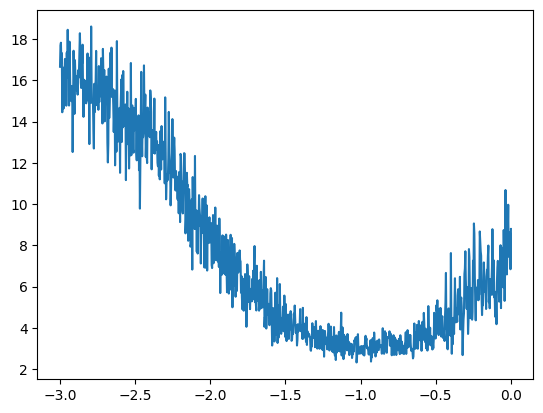

In [100]:
plt.plot(lri, lossi)